In [1]:
%matplotlib inline
from __future__ import print_function,division
import os, sys, datetime, glob
from collections import OrderedDict
from functools import partial
import numpy as np

import matplotlib.pyplot as plt

try:
    from importlib import reload # Python 3
except ImportError:
    pass

import torch
print(torch.__version__)

from IPython.core.display import display, HTML, clear_output
display(HTML("<style>.container { width:90% !important; }</style>"))

sys.path.append('..')
import trainimagesource, trainutils, datasource

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation']='none'

os.environ['CUDA_VISIBLE_DEVICES'] = '0'


0.4.0


In [2]:
imwidth = 256
imheight = 256
numimgs = 500

def createTestImage(width,height,numObjs=12,radMax=30):
    '''Return a noisy 2D image with `numObj' circles and a 2D mask image.'''
    image=np.zeros((width,height))
    
    for i in range(numObjs):
        x=np.random.randint(radMax,width-radMax)
        y=np.random.randint(radMax,height-radMax)
        rad=np.random.randint(10,radMax)
        spy,spx = np.ogrid[-x:width-x, -y:height-y]
        circle=(spx*spx+spy*spy)<=rad*rad
        image[circle]=np.random.random()*0.5+0.5
    
    norm=np.random.uniform(0,1.0,size=image.shape)
    
    return np.maximum(image,norm).astype(float),(image>0).astype(float)

def plotPair(im1,im2):
    '''Convenience function for plotting two images side-by-side.'''
    fig, ax = plt.subplots(1, 2, figsize=(10,5))
    ax[0].imshow(im1)
    ax[1].imshow(im2)
    
dataset=[createTestImage(imwidth,imheight) for _ in range(numimgs)]
imgin=np.concatenate([(d[0],) for d in dataset])[...,np.newaxis]
maskin=np.concatenate([(d[1],) for d in dataset])

306 ms ± 42.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(100, 256, 256, 1) (100, 256, 256)


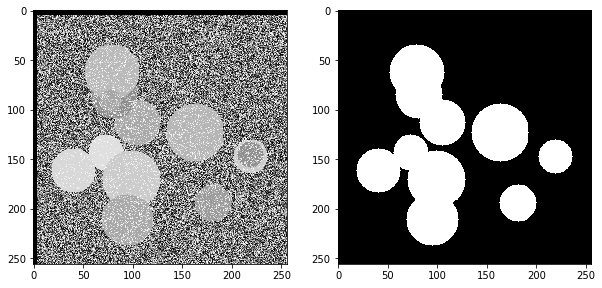

In [3]:
datasource=reload(datasource)

augs=[lambda i,m:(i,m.astype(np.float32)),
      trainimagesource.rot90BothAugment, trainimagesource.transposeBothAugment,trainimagesource.flipBothAugment,
      partial(trainimagesource.shiftMaskAugment,dimfract=15,order=0),
#       pytorchutils.convertAug
]


dsrc=datasource.DataSource(imgin,maskin,augments=augs)

# %timeit dsrc.getIndexBatch(np.arange(100))
# %timeit dsrc.getRandomBatch(100)

with dsrc.threadBatchGen(100,1) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
plotPair(imgs[0,...,0],masks[0])

In [4]:
datasource=reload(datasource)

augs=[lambda i,m:(i,m.astype(np.float32)),
      trainimagesource.rot90BothAugment, trainimagesource.transposeBothAugment,trainimagesource.flipBothAugment,
      #partial(trainimagesource.shiftMaskAugment,dimfract=15,order=0),
#       pytorchutils.convertAug
]


dsrc=datasource.DataSource(imgin,maskin,augments=augs)


with dsrc.processBatchGen(100,1) as gen:
    imgs,masks=gen()
    %timeit gen()

print(imgs.shape,masks.shape)
plotPair(imgs[0,...,0],masks[0])

Process ForkPoolWorker-1:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-2:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-13:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  F

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-24:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-35:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../d

  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-46:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
Ty

  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-57:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-58:
Traceback (most recent call last):
  File "/home/localek10/m

TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-68:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-69:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/p

Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-80:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._targ

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-91:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-102:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../

  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-113:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
T

  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-124:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-125:
Traceback (most recent call last):
  File "/home/localek10

TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-135:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-136:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib

Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-147:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._tar

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-158:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initarg

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-169:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../

  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-180:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
T

KeyboardInterrupt: 

Process ForkPoolWorker-186:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-187:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", l

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-198:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-209:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initarg

  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-220:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../

  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
TypeError: arg 5 (closure) must be tuple
Process ForkPoolWorker-231:
Traceback (most recent call last):
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/localek10/miniconda3/lib/python3.6/multiprocessing/pool.py", line 103, in worker
    initializer(*initargs)
  File "../datasource.py", line 110, in init
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
  File "../datasource.py", line 110, in <listcomp>
    augments=[types.FunctionType(marshal.loads(a),globals()) for a in augments_]
T

In [ ]:
import marshal,types

def f(x,y=0):
    print(x,y)
    
m=marshal.dumps((lambda x:f(x)).__code__)
ff=types.FunctionType(marshal.loads(m),globals())

ff(1)